<center><h1> <font color="green"><u>Active-Case Predictions ~ 19-nCoV</u></font> </h1></center>

<center><h3> <font color="#cc0000"><u>Active Cases(%) out of Confirmed</u></font> </h3></center>

<h3> <font color="purple"><u>This section includes:</u></font> </h3>

> * Data Filtering <br />
> * Training & Testing datasets <br />
> * Prediction <br />
> * Visualization (Scatter Plots) <br />

<br />

## Creating Datasets

In [1]:
# setting the working directory
setwd("~/Documents/A-tracking-of-2019-nCoV/COVID-19/ready_to_use")

In [2]:
# Loading desired libraries
library(ggplot2)
library(stringr)

# loading plotting/machine learning
library(tidyverse)
library(caret)
library(mlbench)
library(kernlab)
library(rpart)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.1     ✔ purrr   0.3.3
✔ tidyr   1.0.2     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘kernlab’


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    alpha




<hr />

In [3]:
# includes data of all the countries
all = read.csv('COVID-19/Mixed/countryWise_bulk_summary.csv')

# includes data of four majour location
four = read.csv('COVID-19/FOUR/Four_dataset_locationWise.csv')

In [4]:

# extracting the desired dataset
extractDatases <- function(region){
    if(region %in% c("Hubei", "World", "Diamond Princess")) {
    temp = four[which(str_detect(four$Location, region)),]
    row.names(temp) <- NULL
} else {
    temp = all[which(str_detect(all$Country, region)),]
    row.names(temp) <- NULL
}

return(temp)
}


In [5]:
# country list
countries = matrix(levels(as.factor(all$Country)))
#head(countries, 10)

# Four majour locations
locations = matrix(levels(as.factor(four$Location)))
#locations

<br /> 
### Choosing desired Country/Region

In [17]:
# country i.e. to be used throughout the analysis
 rName = "China" # without hubei

# some other possible values of rName:
# 'World', 'Hubei', 'Diamond Cruise', 'Italy', 'Japan'.....etc

<hr />

In [18]:
# filtering out desired country/location 
if(rName == "China"){
    region1 = extractDatases(rName)

    # joining Hubei for complete data of china
    region2 = extractDatases("Hubei")

    region = cbind(region1[,1:3], region1[,4:8]+region2[,4:8])
    colnames(region) <- colnames(region1)
} else {
    region = extractDatases(rName)
}

tail(region)

,Country,Day,Date,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases
56,China,56,17-03-2020,81058,3230,68798,9030,72028
57,China,57,18-03-2020,81103,3241,69755,8107,72996
58,China,58,19-03-2020,81157,3249,70535,7373,73784
59,China,59,20-03-2020,81251,3253,71266,6732,74519
60,China,60,21-03-2020,81306,3259,71857,6190,75116
61,China,61,22-03-2020,81398,3265,72362,5771,75627


<hr />

In [19]:
region=region[,c(2, 4:8)]
head(region, 10)

Day,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases
1,548,17,28,503,45
2,643,18,30,595,48
3,920,26,36,858,62
4,1406,42,39,1325,81
5,2075,56,49,1970,105
6,2877,82,58,2737,140
7,5509,131,101,5277,232
8,6087,133,120,5834,253
9,8141,171,135,7835,306
10,9802,213,214,9375,427


In [20]:
# calculate the percent (using Confirmed cases as total)
percent <- function(dfName){
    get(dfName) -> df
    part <- NULL
    
    for(i in 1:nrow(df)) {
        val = df[i,"Active.Cases"]
        Total = df[i,"Confirmed"]
        
        
        if(i == 1)
            if(val==0)
                part = 0
            else
                part = as.numeric((val*100)/Total)
        else
            if(val==0)
                part = c(part, 0)
            else
                part <- c(part, as.numeric((val*100)/Total))
    }
        
    return(part)
}

<hr />

In [21]:
# CASES -> percentage
region$'percent_active' = percent("region")     # Active cases, out of every 100 Confirmed cases
region$'percent_closed' = 100-percent("region") # Closed cases, out of every 100 Confirmed cases

In [22]:
tail(region)

,Day,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases,percent_active,percent_closed
56,56,81058,3230,68798,9030,72028,11.140171,88.85983
57,57,81103,3241,69755,8107,72996,9.995931,90.00407
58,58,81157,3249,70535,7373,73784,9.084860,90.91514
59,59,81251,3253,71266,6732,74519,8.285436,91.71456
60,60,81306,3259,71857,6190,75116,7.613214,92.38679
61,61,81398,3265,72362,5771,75627,7.089855,92.91015


In [23]:
#write.csv(region, file = "COVID-19/regionToPredictActive.csv")

<br />* Dataset is ready

<hr /><br />

### Understanding the plot

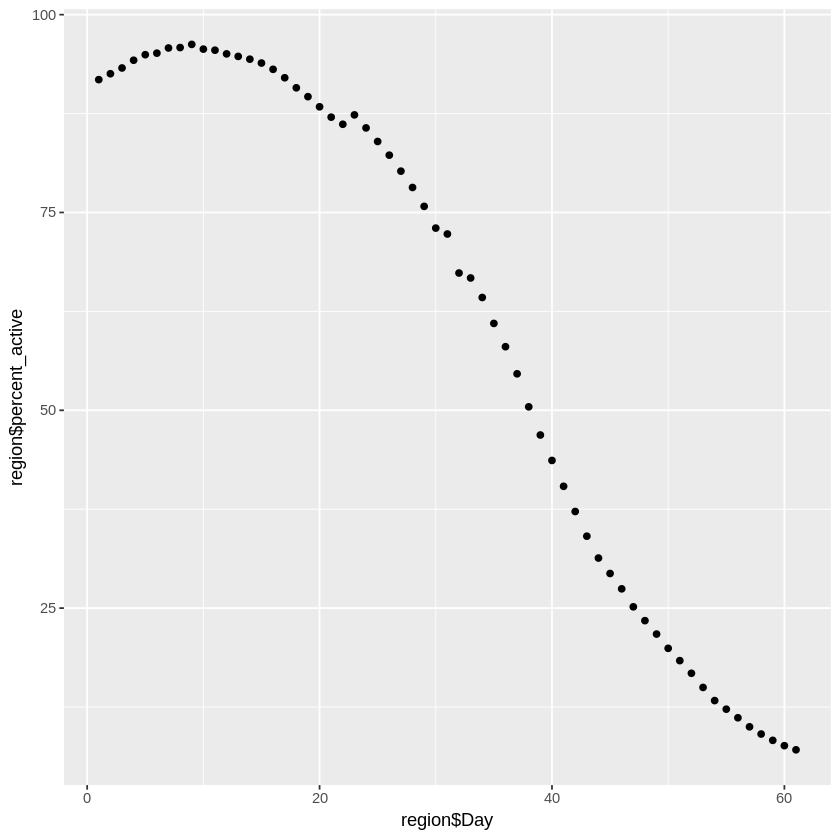

In [24]:
# Day vs %Closed Cases
region.scatter.plot <- ggplot(region, aes(x = region$Day, y = region$percent_active)) +
                        geom_point()
region.scatter.plot

In [25]:
tail(region)

,Day,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases,percent_active,percent_closed
56,56,81058,3230,68798,9030,72028,11.140171,88.85983
57,57,81103,3241,69755,8107,72996,9.995931,90.00407
58,58,81157,3249,70535,7373,73784,9.084860,90.91514
59,59,81251,3253,71266,6732,74519,8.285436,91.71456
60,60,81306,3259,71857,6190,75116,7.613214,92.38679
61,61,81398,3265,72362,5771,75627,7.089855,92.91015


<br /><hr /><br />

## Data-Analysis <br />

In [26]:
# setting the theme
theme_set(theme_classic())

In [27]:
set.seed(20) # generages same set of random sample every time

training.samples <- region$Day %>%
  createDataPartition(p = 0.8, list = FALSE)

train.data  <- region[training.samples, ]
test.data <- region[-training.samples, ]

In [28]:
tail(train.data, 3)
head(test.data, 3)

,Day,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases,percent_active,percent_closed
59,59,81251,3253,71266,6732,74519,8.285436,91.71456
60,60,81306,3259,71857,6190,75116,7.613214,92.38679
61,61,81398,3265,72362,5771,75627,7.089855,92.91015


,Day,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases,percent_active,percent_closed
4,4,1406,42,39,1325,81,94.23898,5.761024
13,13,19716,425,615,18676,1040,94.72510,5.274904
16,16,30587,633,1480,28474,2113,93.09184,6.908164


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



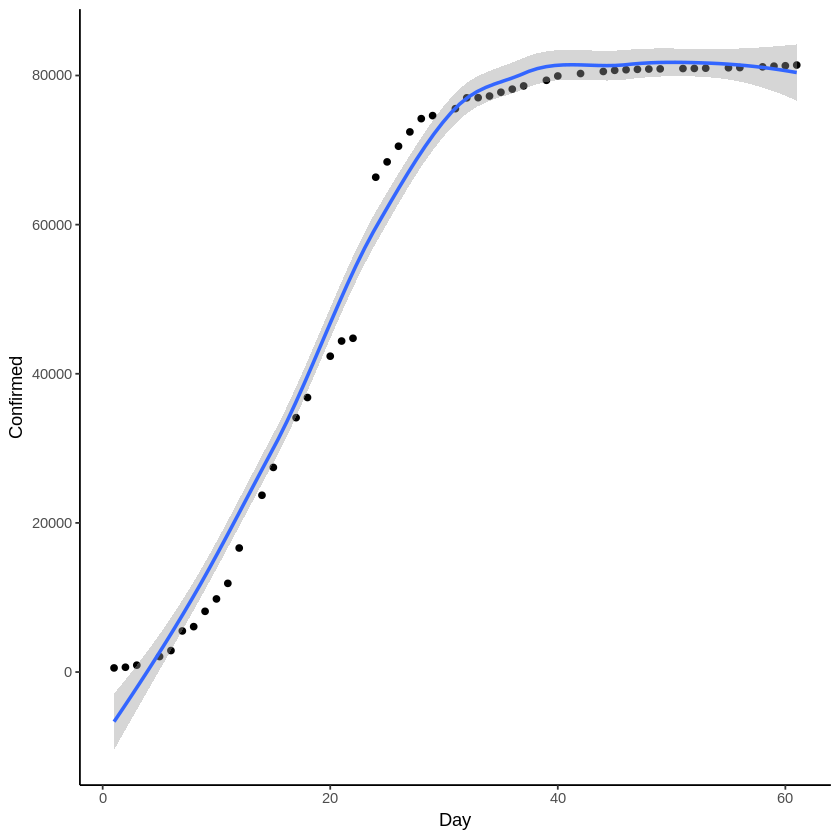

In [82]:
ggplot(train.data, aes(Day, percent_active) ) +
  geom_point() +
  stat_smooth()

<br /><hr /><br />

## Regrassion

### 1. Linear regression

In [32]:
# building linear model
fit.lm = lm(Day ~ percent_active, data = train.data)
#summary(fit.lm)

In [33]:
#Residual Standard error (Like Standard Deviation)
k=length(fit.lm$coefficients)-1
#Multiple R-Squared (Coefficient of Determination)
SSyy=sum((train.data$percent_active-mean(train.data$percent_active))**2)
    
SSE=sum(fit.lm$residuals**2)
n=length(fit.lm$residuals)
    
# final
rmse = sqrt(SSE/(n-1))
rse = sqrt(SSE/(n-(1+k))) #Residual Standard Error
r2 = (SSyy-SSE)/SSyy


# Model performance
data.frame(
       RMSE = rmse,
       RSE = rse,
       R2 = r2
     )

RMSE,RSE,R2
4.871916,4.923472,0.9779425


<br />

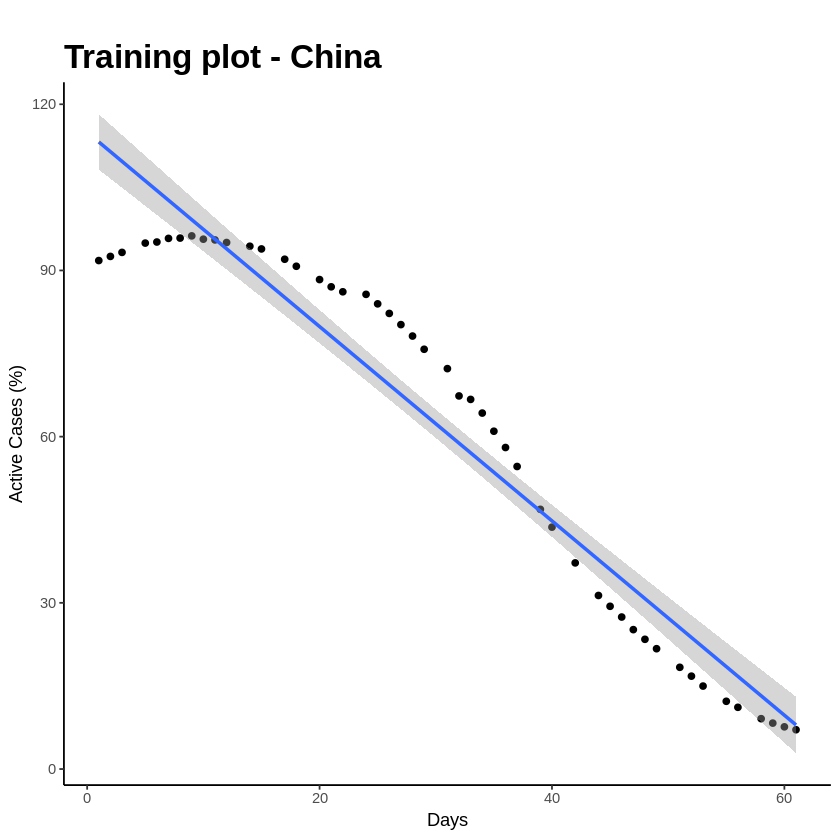

In [34]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

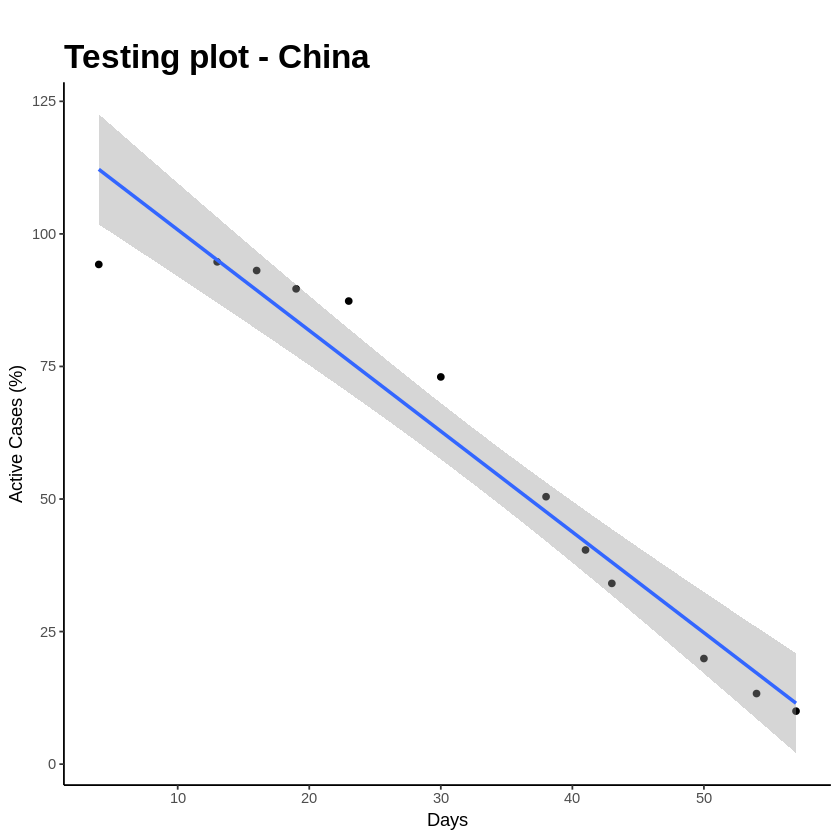

In [35]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br />

In [36]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.lm, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.lm, test.data)
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
56,56,11.140171,57.09636
58,58,9.084860,58.18231
59,59,8.285436,58.60470
60,60,7.613214,58.95988
61,61,7.089855,59.23640


,Day,percent_active,Pridicted_percent_active
41,41,40.391335,41.64113
43,43,34.088025,44.97157
50,50,19.915720,52.45969
54,54,13.311853,55.94893
57,57,9.995931,57.70094


<br />

### 2. Polynomial regression

In [83]:
# Model performance
plm.predictions = data.frame(
  Degree = NULL,
  RMSE = NULL,
  RSE = NULL,
  R2 = NULL
)


for(deg in 1:14){
    
    # building polynomial model
    fit.plm = lm(percent_active ~ poly(Day, deg, raw = TRUE), data = train.data)
    #summary(fit.plm)

    
    #Residual Standard error (Like Standard Deviation)
    k=length(fit.plm$coefficients)-1
    #Multiple R-Squared (Coefficient of Determination)
    SSyy=sum((train.data$percent_active-mean(train.data$percent_active))**2)
    
    SSE=sum(fit.plm$residuals**2)
    n=length(fit.plm$residuals)
    
    
    # final
    rmse = sqrt(SSE/(n-1))
    rse = sqrt(SSE/(n-(1+k))) #Residual Standard Error
    r2 = (SSyy-SSE)/SSyy
    
    temp <- data.frame(
                        Degree = deg,
                        RMSE = rmse,
                        RSE = rse,
                        R2 = r2
                      )
    
    plm.predictions = rbind(plm.predictions, temp)
}

plm.predictions#[which(plm.predictions$RMSE == min(plm.predictions$RMSE)),]

Degree,RMSE,RSE,R2
1,13685.853,13830.681,0.8074545
2,6055.689,6185.933,0.9623021
3,5845.801,6037.517,0.9648700
4,3100.453,3238.317,0.9901181
5,2741.521,2896.530,0.9922737
6,2459.457,2629.270,0.9937818
7,2244.638,2428.706,0.9948206
8,2182.788,2391.124,0.9951021
9,2051.108,2275.500,0.9956752
10,2012.530,2261.889,0.9958363


In [103]:
deg = 11  # degree of polynomial

# building polynomial model
fit.plm = lm(percent_active ~ poly(Day, deg, raw = TRUE), data = train.data)
#summary(model)

In [104]:
p = predict(fit.plm, train.data)

# Model performance
data.frame(
  RMSE = RMSE(p, train.data$Day),
  R2 = R2(p, train.data$Day)
)

RMSE,R2
58.43014,0.9269859


<br />

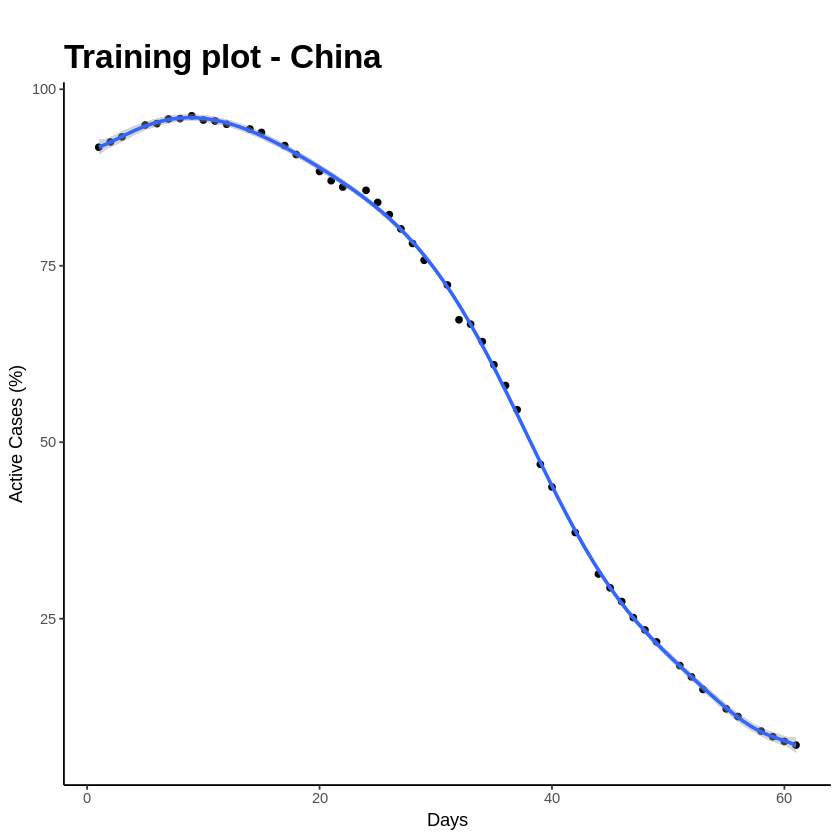

In [105]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

Warning message in predict.lm(model, newdata = data.frame(x = xseq), se.fit = se, :
“prediction from a rank-deficient fit may be misleading”


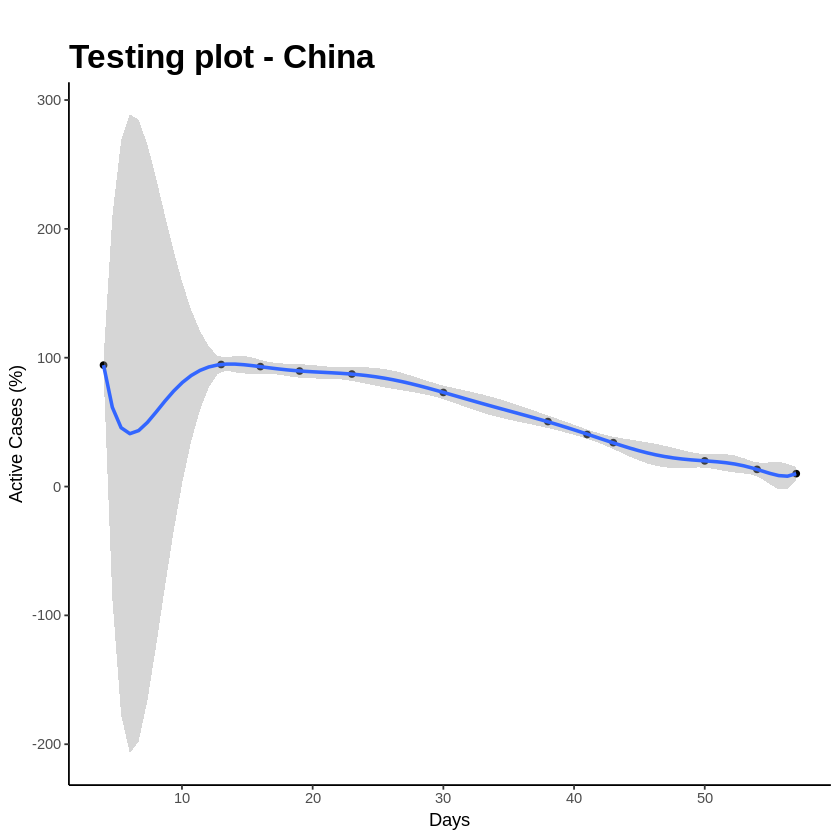

In [106]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br /><br />

In [107]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.plm, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.plm, test.data)
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
56,56,11.140171,11.028721
58,58,9.084860,8.962869
59,59,8.285436,8.273719
60,60,7.613214,7.726603
61,61,7.089855,7.052953


,Day,percent_active,Pridicted_percent_active
41,41,40.391335,40.568814
43,43,34.088025,34.577671
50,50,19.915720,19.871507
54,54,13.311853,13.769585
57,57,9.995931,9.884036


<br /> 
### 3. SVMK Regression

In [43]:
# model
fit.svmk <- ksvm(percent_active~Day, train.data, kernel="rbfdot")
#summary(fit.svmk)

In [44]:
predictions <- fit.svmk %>% predict(train.data)

In [45]:
# Model performance
data.frame(
  RMSE = RMSE(predictions, train.data$Day),
  R2 = R2(predictions, train.data$Day)
)

RMSE,R2
56.09764,0.9327179


<br />

In [46]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.svmk, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.svmk, test.data)
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
56,56,11.140171,12.99178
58,58,9.084860,10.66103
59,59,8.285436,10.37194
60,60,7.613214,10.89096
61,61,7.089855,12.32159


,Day,percent_active,Pridicted_percent_active
41,41,40.391335,42.50173
43,43,34.088025,37.08894
50,50,19.915720,23.26419
54,54,13.311853,16.44586
57,57,9.995931,11.59714


<br />

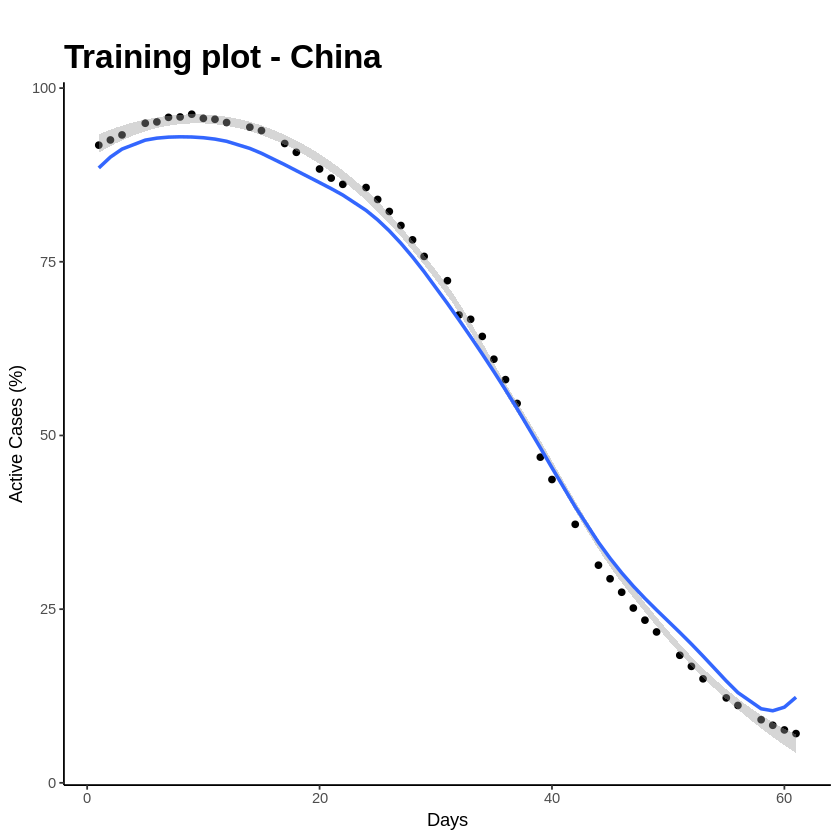

In [47]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=trained, method="loess", size=0) +
              geom_line(data = trained, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

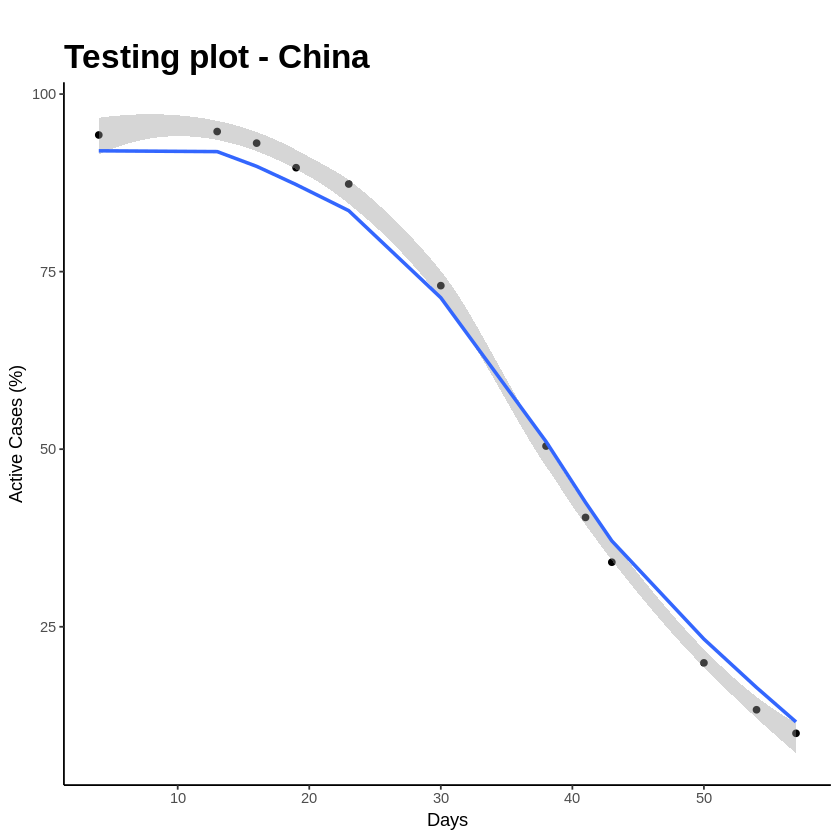

In [48]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=tested, method="loess", size=0) +
              geom_line(data = tested, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br /> 
### 4. KNN Regression

In [63]:
x <- as.matrix(train.data[,1])
y <- as.matrix(train.data[,7])

In [64]:
# fit model
fit.knn <- knnreg(x, y, k=2)
#summary(fit.knn)

In [65]:
predictions <- fit.knn %>% predict(x)

In [66]:
data.frame(
  RMSE = RMSE(predictions, x),
  R2 = R2(predictions, x)
)

RMSE,R2
58.40671,0.9269771


<br />

In [53]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.knn, as.matrix(train.data[,1]))
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.knn, as.matrix(test.data[,1]))
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
56,56,11.140171,11.682410
58,58,9.084860,8.685148
59,59,8.285436,8.327837
60,60,7.613214,7.662835
61,61,7.089855,7.351535


,Day,percent_active,Pridicted_percent_active
41,41,40.391335,40.43411
43,43,34.088025,34.26791
50,50,19.915720,20.03890
54,54,13.311853,13.59840
57,57,9.995931,10.11252


<br />

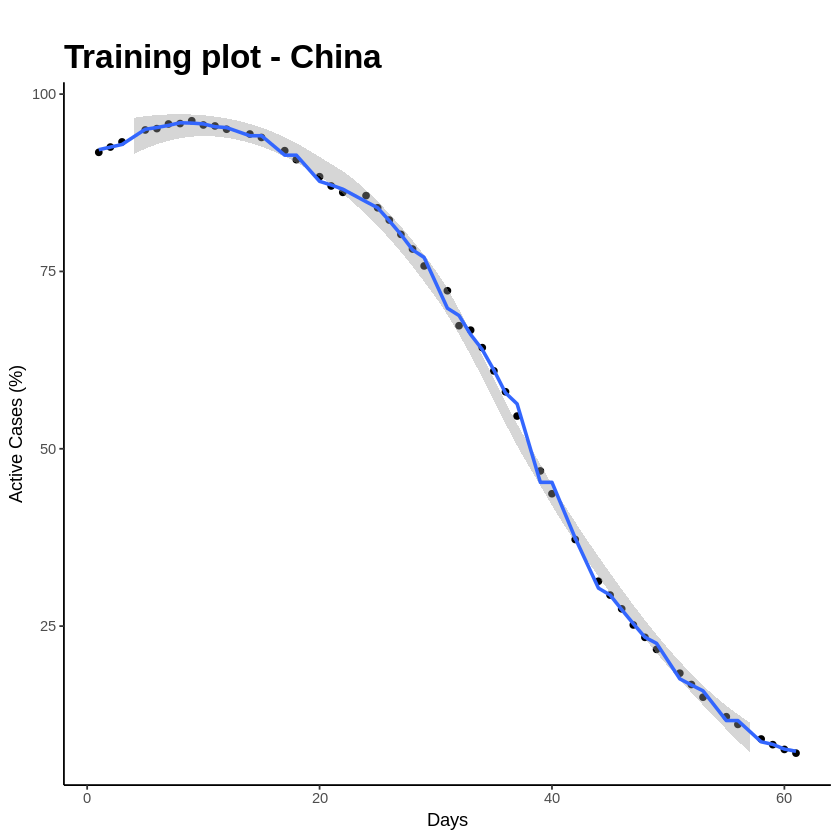

In [54]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=tested, method="loess", size=0) +
              geom_line(data = trained, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

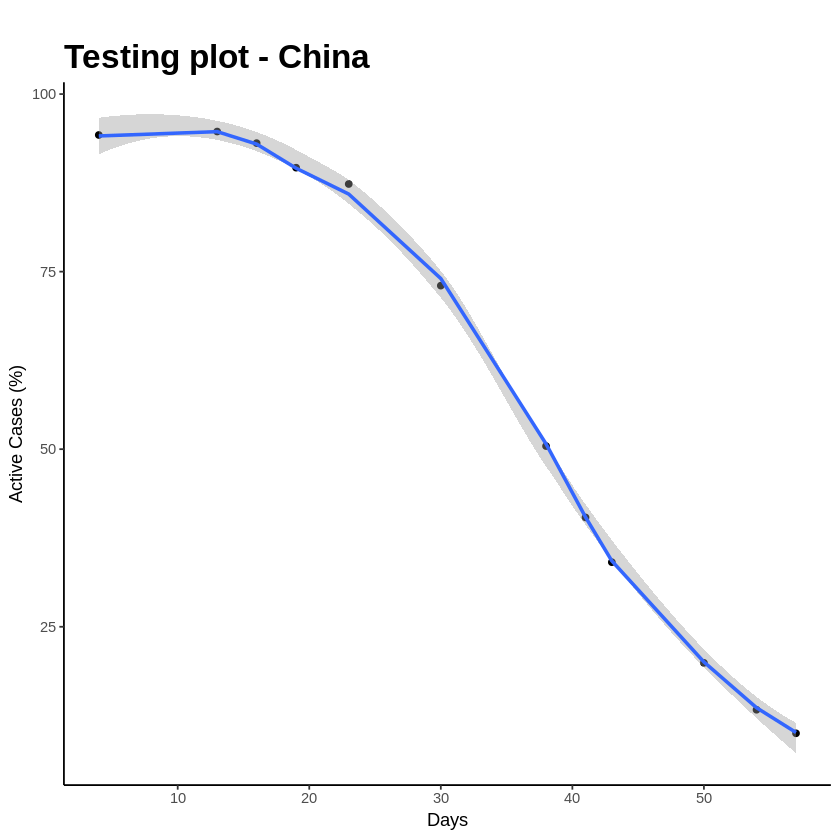

In [55]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=tested, method="loess", size=0) +
              geom_line(data = tested, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br />

<br /><hr /><br />

## Predictions

In [56]:
test_Miscellaneous = data.frame(
                        Day = rep(NaN, 13),
                        #Confirmed = NaN,
                        #Active.Cases = NaN,
                        percent_active = 8.2854
                        #percent_closed = NaN
                     )

In [57]:
# 13th March ---> day 52
dNo = c(55:67)    # get the day no. to pridict

test_Miscellaneous$'Day' = dNo

<br /> 
2. #### By New Model

In [108]:
# modeling variable  --->  fit

Prediction = cbind(
                "Day" = 55:67,
                "Active (%)" = c(region[55:61,"percent_active"],rep(NaN, 7)),
                "By SVMK M." = as.numeric(predict(fit.svmk, test_Miscellaneous)),
                "By KNN M." = predict(fit.knn, as.matrix(test_Miscellaneous[,1])),
                "By Poly M." = predict(fit.plm, test_Miscellaneous),
                "By Linear M." = predict(fit.lm, test_Miscellaneous)
             )
Prediction

#train.data

Warning message in cbind(Day = 55:67, `Active (%)` = c(region[55:61, "percent_active"], :
“number of rows of result is not a multiple of vector length (arg 1)”


Day,Active (%),By SVMK M.,By KNN M.,By Poly M.,By Linear M.
55,12.224649,14.66001,11.682410,12.344438,58.60472
56,11.140171,12.99178,11.682410,11.028721,58.60472
57,9.995931,11.59714,10.112516,9.884036,58.60472
58,9.084860,10.66103,8.685148,8.962869,58.60472
59,8.285436,10.37194,8.327837,8.273719,58.60472
60,7.613214,10.89096,7.662835,7.726603,58.60472
61,7.089855,12.32159,7.351535,7.052953,58.60472
62,NaN,14.68679,7.351535,5.692816,58.60472
63,NaN,17.91896,7.351535,2.640982,58.60472
64,NaN,21.86518,7.351535,-3.757794,58.60472


In [76]:
class(predict(fit.knn, as.matrix(test_Miscellaneous[,1])))

[1] "numeric"

<br /> 
1. #### By Old Model

In [109]:
# modeling variable  --->  fit

Prediction = cbind(
                "Day" = 55:67,
                "Active (%)" = c(region[55:61,"percent_active"],rep(NaN, 7)),
                "By SVMK M." = as.numeric(predict(fit.svmk, test_Miscellaneous)),
                "By KNN M." = predict(fit.knn, as.matrix(test_Miscellaneous[,1])),
                "By Poly M." = predict(fit.plm, test_Miscellaneous),
                "By Linear M." = predict(fit.lm, test_Miscellaneous)
             )
Prediction

#train.data

Warning message in cbind(Day = 55:67, `Active (%)` = c(region[55:61, "percent_active"], :
“number of rows of result is not a multiple of vector length (arg 1)”


Day,Active (%),By SVMK M.,By KNN M.,By Poly M.,By Linear M.
55,12.224649,14.66001,11.682410,12.344438,58.60472
56,11.140171,12.99178,11.682410,11.028721,58.60472
57,9.995931,11.59714,10.112516,9.884036,58.60472
58,9.084860,10.66103,8.685148,8.962869,58.60472
59,8.285436,10.37194,8.327837,8.273719,58.60472
60,7.613214,10.89096,7.662835,7.726603,58.60472
61,7.089855,12.32159,7.351535,7.052953,58.60472
62,NaN,14.68679,7.351535,5.692816,58.60472
63,NaN,17.91896,7.351535,2.640982,58.60472
64,NaN,21.86518,7.351535,-3.757794,58.60472


<br /> 
3. #### By SVMK Model

In [69]:
# modeling variable  --->  model
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_active")],
                percent_pridicted = predict(fit.svmk, test_Miscellaneous)
             )
Prediction

Day,percent_active,percent_pridicted
55,8.2854,14.66001
56,8.2854,12.99178
57,8.2854,11.59714
58,8.2854,10.66103
59,8.2854,10.37194
60,8.2854,10.89096
61,8.2854,12.32159
62,8.2854,14.68679
63,8.2854,17.91896
64,8.2854,21.86518


<br /> 
3. #### By KNN Model

In [67]:
# modeling variable  --->  model
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_active")],
                percent_pridicted = predict(fit.knn, as.matrix(test_Miscellaneous[,1]))
             )
Prediction[]

Day,percent_active,percent_pridicted
55,8.2854,11.682410
56,8.2854,11.682410
57,8.2854,10.112516
58,8.2854,8.685148
59,8.2854,8.327837
60,8.2854,7.662835
61,8.2854,7.351535
62,8.2854,7.351535
63,8.2854,7.351535
64,8.2854,7.351535


<hr /> <br />

In [45]:
# world on day 58
# 92.63192 ---> @deg = 16
# 88.90763 ---> @deg = 19